# T5 DET/ROC Curve Visualization

# 1. ROC Curve Plotting

In this notebook we will plot the DET / ROT curve.

## Background Knowledge

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

https://checkmyai.com/index.php?get=methods

<img src="https://checkmyai.com/images/roc.png" width="400px"/>

## Initialization

In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from Model import T5Sentinel
from sklearn.metrics import auc

from tqdm.notebook import tqdm

In [11]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_WEBTEXT = Path(PATH_ROOT, "data", "open-web-text-split")
PATH_GPTTEXT = Path(PATH_ROOT, "data", "open-gpt-text-split")

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_FIG   = Path(PATH_ROOT, "result", "figures", "ROC")
PATH_DET_FIG = Path(PATH_ROOT, "result", "figures", "DET")

PATH_CHECKPT = Path(PATH_CACHE, "t5.small.0422.pt")

In [12]:
class DualDataset(torch.utils.data.Dataset):
    def __init__(self, webTextPath: str, gptTextPath: str) -> None:
        super().__init__()

        # load from filesystem

        gptText = pd.read_json(gptTextPath, lines=True)['text']
        gptUID  = pd.read_json(gptTextPath, lines=True)['uid']
        all_uids = {uid for uid in gptUID}

        webData = pd.read_json(webTextPath, lines=True)
        webData = webData.loc[webData['uid'].isin(all_uids)]
        webText = webData["text"]
        webUID  = webData["uid"]

        # label accordingly
        self.data = [(text, 0) for text in webText] + [(text, 1) for text in gptText]
        self.uid  = [(uid, 0) for uid in webUID] + [(uid, 1) for uid in gptUID]
        self.length = len(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index: int):
        return self.data[index], self.uid[index]

In [13]:
checkpoint = torch.load(PATH_CHECKPT, map_location="cpu")
print(checkpoint.keys())

dict_keys(['epochIter', 'model', 'optimizer', 'scheduler', 'validAccuracy'])


Now we want to load our model and setup the dataset

In [14]:
clean_model = T5Sentinel()

print("Loading model with validation accuracy", checkpoint["validAccuracy"])
clean_model.load_state_dict(checkpoint["model"])
clean_model = clean_model.to("cuda")
clean_model.eval()

clean_dataset = DualDataset(
    webTextPath=str(Path(PATH_WEBTEXT, "test.jsonl")),
    gptTextPath=str(Path(PATH_GPTTEXT, "test.jsonl"))
)

Loading model with validation accuracy 0.9727494577006508


## Clean model visualization

The "clean" model is the model trained on normalized dataset. We will first calculate the probability pair for every element in the test dataset

In [15]:
prediction_cache_path = Path(PATH_CACHE, "t5_pred_clean_data.pt")

if prediction_cache_path.exists():
    print("Using existing cache")
    prediction_result = torch.load(prediction_cache_path)
else:
    print("Doesn't find existing cache, rerun the model")
    # Prediction result is a list
    prediction_result = dict()

    for index in tqdm(range(len(clean_dataset))):
        (text, label), (uid, _) = clean_dataset[index]
        uid += "-web" if label == 0 else "-gpt"

        pred, _ = clean_model(text)
        pred = pred.detach().cpu().numpy().flatten()
        prediction_result[uid] = pred

    torch.save(prediction_result, prediction_cache_path)

Doesn't find existing cache, rerun the model


  0%|          | 0/4213 [00:00<?, ?it/s]

In [16]:
def calculate_ROC(prediction, threshold):
    # Positive -> Real, Negative -> Fake
    TP, TN, FP, FN = 0, 0, 0, 0
    for key in prediction:
        label = key.endswith("web")
        # print(prediction[key], label)
        # prediction[key] = (fake, real)
        y_hat = prediction[key][1] > threshold

        if label == True and y_hat == True: TP += 1
        elif label == True and y_hat == False: FN += 1
        elif label == False and y_hat == True: FP += 1
        else: TN += 1
    return TP, TN, FP, FN

print("Statistics under standard threshold (p = 0.5)", calculate_ROC(prediction_result, 0.5))

Statistics under standard threshold (p = 0.5) (1243, 2906, 38, 26)


### "Clean Model" on "Clean Dataset" ROC Curve

In [17]:
def calcROCCurve(prediction, start=0, end=1, precision=0.01):
    TPs, TNs, FPs, FNs = [], [], [], []
    TPRs, FPRs = [], []
    for thresh in tqdm(range(start, int(end / precision) + 1)):
        thresh = thresh * precision
        TP, TN, FP, FN = calculate_ROC(prediction, thresh)
        TPs.append(TP)
        TNs.append(TN)
        FPs.append(FP)
        FNs.append(FN)
        TPRs.append(TP / (TP + FN))
        FPRs.append(FP / (FP + TN))
    return TPRs, FPRs, [TPs, TNs, FPs, FNs]

In [18]:
clean_TPRs, clean_FPRs, _ = calcROCCurve(prediction_result, precision=1e-3)

  0%|          | 0/1001 [00:00<?, ?it/s]

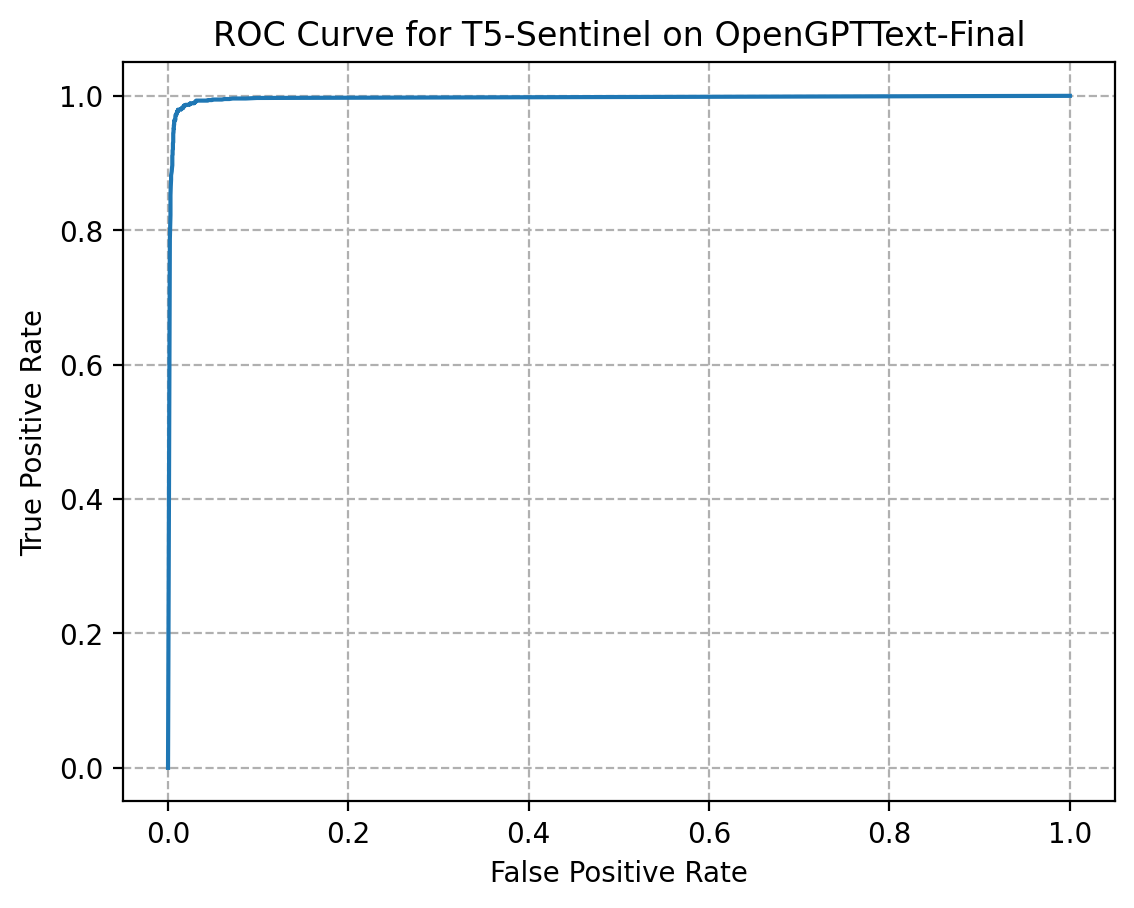

In [19]:
def plotROCCurve(TPRs, FNRs, fileName, title):
    fig: plt.Figure = plt.figure(dpi=200)
    FPR_arr = np.array(FNRs)
    TPR_arr = np.array(TPRs)
    ax: plt.Axes = fig.add_subplot(1, 1, 1)
    ax.plot(FPR_arr, TPR_arr, label="ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(linestyle="--")
    plt.show()
    fig.savefig(Path(PATH_FIG, fileName))

plotROCCurve(
    clean_TPRs, clean_FPRs,
    "t5_ROC_Curve-cleanData.pdf",
    "ROC Curve for T5-Sentinel on OpenGPTText-Final"
)

### Estimate the Area Under Curve (AUC) for Clean Model

In [20]:
print("Clean Model on Clean Data AUC:", auc(clean_FPRs, clean_TPRs))

Clean Model on Clean Data AUC: 0.9960427587624626


# 2. DET Curve Plotting

In [21]:
def calcDETCurve(prediction, start=0, end=1, precision=0.01):
    TPs, TNs, FPs, FNs = [], [], [], []
    FPRs, FNRs = [], []
    for thresh in tqdm(range(start, int(end / precision) + 1)):
        thresh = thresh * precision
        TP, TN, FP, FN = calculate_ROC(prediction, thresh)
        TPs.append(TP)
        TNs.append(TN)
        FPs.append(FP)
        FNs.append(FN)
        FPRs.append(FP / (FP + TN))
        FNRs.append(FN / (FN + TP))
    return FNRs, FPRs, [TPs, TNs, FPs, FNs]

def plotDETCurve(FNRs, FPRs, fileName, title):
    fig: plt.Figure = plt.figure(dpi=200)
    FNR_arr = np.array(FNRs)
    FPR_arr = np.array(FPRs)
    ax: plt.Axes = fig.add_subplot(1, 1, 1)
    ax.plot(FPR_arr, FNR_arr, label="DET Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("False Negative Rate")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    ax.grid(linestyle="--")
    ax.set_title(title)
    plt.show()
    fig.savefig(Path(PATH_DET_FIG, fileName))

In [22]:
t5_cD_cache = Path(PATH_CACHE, "t5_pred_clean_data.pt")
assert t5_cD_cache.exists()
t5_cD_pred = torch.load(t5_cD_cache)

## Clean Model DET Visualization

In [23]:
cMcD_FNR, cMcD_FPR, _ = calcDETCurve(t5_cD_pred, precision=1e-3)

  0%|          | 0/1001 [00:00<?, ?it/s]

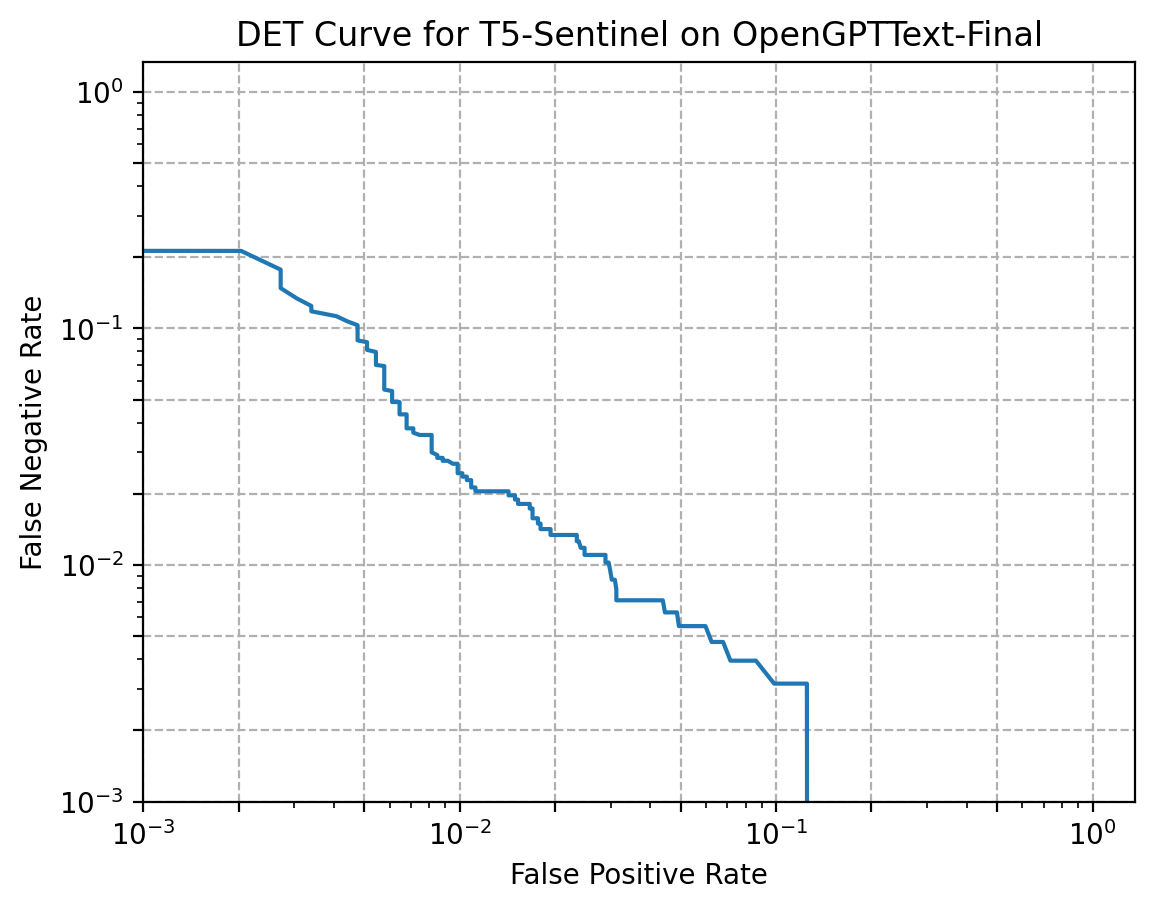

In [24]:
plotDETCurve(cMcD_FNR, cMcD_FPR, "t5_DET_Curve_cleanData.pdf", "DET Curve for T5-Sentinel on OpenGPTText-Final")